In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
print(f"""
Number of lines: {raw_df.shape[0]}
Number of columns: {raw_df.shape[1]}
""")
raw_df.head()


Number of lines: 284807
Number of columns: 31



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe().T


,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V26,284807.0,1.683437e-15,0.482227,-2.604551,-0.326984,-0.052139,0.240952,3.517346
V27,284807.0,-3.660091e-16,0.403632,-22.565679,-0.070840,0.001342,0.091045,31.612198
V28,284807.0,-1.227390e-16,0.330083,-15.430084,-0.052960,0.011244,0.078280,33.847808
Amount,284807.0,8.834962e+01,250.120109,0.000000,5.600000,22.000000,77.165000,25691.160000


In [5]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print(f"""
Examples:
    Total: {total}
    
    Positive: {pos} ({100 * pos / total:.2f}% of total)
    Negative: {neg} ({100 * neg / total:.2f}% of total)
""")


Examples:
    Total: 284807
    
    Positive: 492 (0.17% of total)
    Negative: 284315 (99.83% of total)



In [6]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log_Ammount'] = np.log(cleaned_df.pop('Amount')+eps)
cleaned_df.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log_Ammount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641


In [7]:
from statsmodels.formula.api import ols
import statsmodels.api as sm


results_tukey = pd.DataFrame()
for i in cleaned_df.columns[~cleaned_df.columns.str.contains('Class')]:

    moore_lm = ols(f'{i} ~ C(Class)',data=cleaned_df).fit()
    anova_results = sm.stats.anova_lm(moore_lm, typ=2) 
    r = {'variable':i,'pvalue':anova_results['PR(>F)']['C(Class)'],'fvalue':anova_results['F']['C(Class)']}
    results_tukey = results_tukey.append(r,ignore_index=True)

    
results_tukey.sort_values('fvalue',ascending=False).style.background_gradient(cmap='coolwarm')

,variable,pvalue,fvalue
16,V17,0.000000,33979.168593
13,V14,0.000000,28695.547788
11,V12,0.000000,20749.822361
9,V10,0.000000,14057.979985
15,V16,0.000000,11443.349428
2,V3,0.000000,11014.508305
6,V7,0.000000,10349.605408
10,V11,0.000000,6999.355047
3,V4,0.000000,5163.832114
17,V18,0.000000,3584.380605


In [8]:
select_features = results_tukey.sort_values('fvalue',ascending=False)
select_features = select_features[select_features.pvalue<0.05]
select_features = np.append(select_features.variable.values,'Class')

In [9]:
cleaned_df = cleaned_df[select_features] 

In [10]:

# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)

train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))


train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [11]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print(f"""
Training labels shape:{train_labels.shape}
Validation labels shape:{val_labels.shape}
Test labels shape:{test_labels.shape}
Training features shape: {train_features.shape}
Validation features shape: {val_features.shape}
Test features shape: {test_features.shape}
""")



Training labels shape:(182276,)
Validation labels shape:(45569,)
Test labels shape:(56962,)
Training features shape: (182276, 26)
Validation features shape: (45569, 26)
Test features shape: (56962, 26)



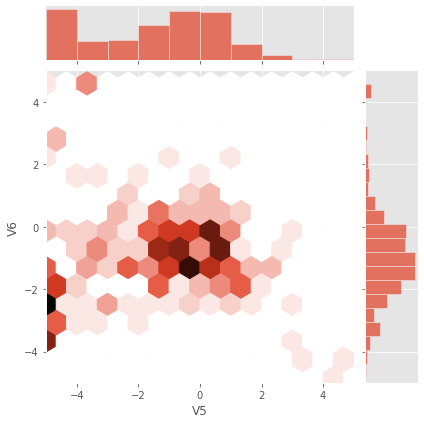

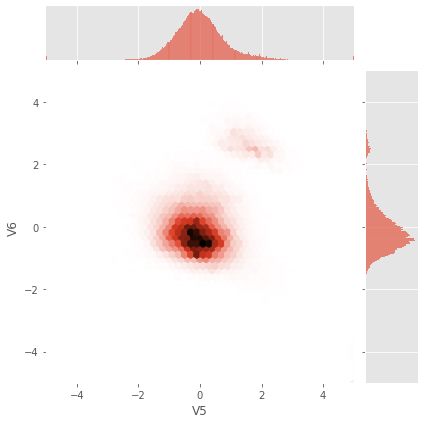

In [12]:
mask_train_labels = train_labels != 0

pos_df = pd.DataFrame(train_features[ mask_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~mask_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],kind='hex', xlim=(-5,5), ylim=(-5,5))
sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],kind='hex', xlim=(-5,5), ylim=(-5,5))

In [69]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=metrics, output_bias=None):
  if output_bias:
    output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.Sequential([
      keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [70]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)




In [71]:
initial_bias = np.log([pos/neg])

model = make_model(output_bias=initial_bias)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                432       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [72]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0173


In [73]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [74]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [75]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [76]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [77]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
90/90 [==============================] - 4s 17ms/step - loss: 3.4321 - tp: 6.0000 - fp: 2.0000 - tn: 363912.0000 - fn: 632.0000 - accuracy: 0.9983 - precision: 0.7500 - recall: 0.0094 - auc: 0.5649 - prc: 0.0415 - val_loss: 0.0081 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 45491.0000 - val_fn: 78.0000 - val_accuracy: 0.9983 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9159 - val_prc: 0.5832
Epoch 2/100
90/90 [==============================] - 0s 5ms/step - loss: 1.8250 - tp: 78.0000 - fp: 28.0000 - tn: 181929.0000 - fn: 241.0000 - accuracy: 0.9985 - precision: 0.7358 - recall: 0.2445 - auc: 0.7930 - prc: 0.3391 - val_loss: 0.0052 - val_tp: 40.0000 - val_fp: 10.0000 - val_tn: 45481.0000 - val_fn: 38.0000 - val_accuracy: 0.9989 - val_precision: 0.8000 - val_recall: 0.5128 - val_auc: 0.9464 - val_prc: 0.6648
Epoch 3/100
90/90 [==============================] - 0s 5ms/step - loss: 1.1449 - tp: 154.0000 - fp: 100.0000 - tn: 181857.0000 - fn: 165.000

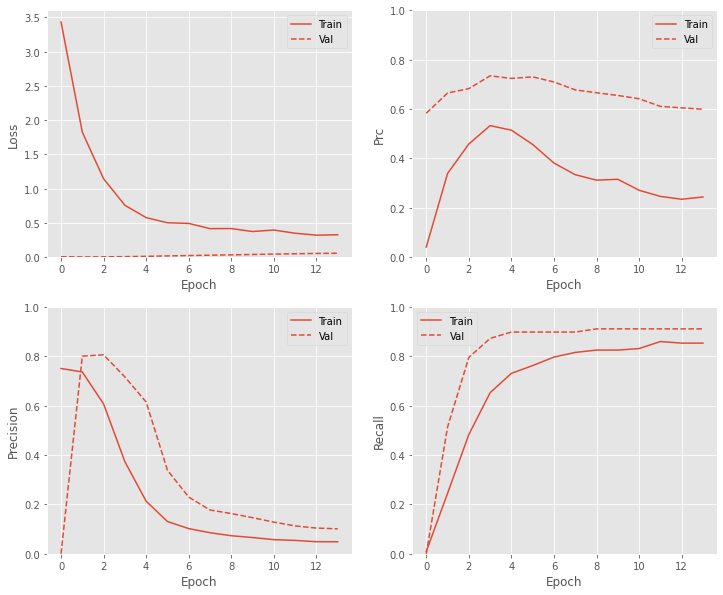

In [78]:
plot_metrics(weighted_history)

28/28 [==============================] - 0s 2ms/step
loss :  0.007364226505160332
tp :  75.0
fp :  15.0
tn :  56852.0
fn :  20.0
accuracy :  0.9993855357170105
precision :  0.8333333134651184
recall :  0.7894737124443054
auc :  0.9500426650047302
prc :  0.7823925018310547
Legitimate Transactions Detected (True Negatives):  56852
Legitimate Transactions Incorrectly Detected (False Positives):  15
Fraudulent Transactions Missed (False Negatives):  20
Fraudulent Transactions Detected (True Positives):  75
Total Fraudulent Transactions:  95


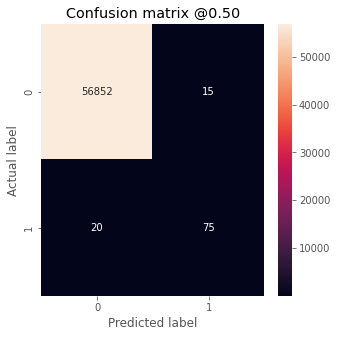

In [79]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)

plot_cm(test_labels, test_predictions_weighted)